# Sorter on generated dataset with drift

Here we will simulate 5min of a very simple dataset one tetrode with 5 units with this time we are introducing a drift!



In [1]:
# this is for debuging
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# some imports
from pathlib import Path
import shutil

import numpy as np

import matplotlib.pyplot as plt

import spikeinterface.full as si

In [3]:
# the path where we want to run the spike sorting
base_folder = Path("/home/samuel/DataSpikeSorting/WIRED_SI_tutos/generated_recording/")


In [4]:
job_kwargs = dict(n_jobs=-1, progress_bar=True, chunk_duration="1s")

## Generate data

spikeinterface have a from simple to sophisticated way of generating fake dataset with the grountruth

Here we simulated a simple recording of 5 min with 5 units on a tetrode.

In [5]:
from generate_drift import generate_drift_on_tetrode

recording, gt_sorting = generate_drift_on_tetrode(drift_amplitude=20., duration=300., noise_level=5., seed=1234)

## SortingAnalyzer on the groundtruth

In [6]:
gt_analyzer = si.create_sorting_analyzer(gt_sorting, recording, sparse=False)
gt_analyzer.compute(["random_spikes", "waveforms", "templates", "noise_levels"], **job_kwargs)
gt_analyzer.compute(["spike_amplitudes", "unit_locations", "principal_components", "correlograms", "template_similarity"], **job_kwargs)
gt_analyzer.compute("quality_metrics", metric_names=["snr", "amplitude_cutoff", "rp_violation"])
gt_analyzer

compute_waveforms:   0%|          | 0/300 [00:00<?, ?it/s]

spike_amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/5 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/5 [00:00<?, ?it/s]

SortingAnalyzer: 4 channels - 5 units - 1 segments - memory - has recording
Loaded 10 extenstions: random_spikes, waveforms, templates, noise_levels, spike_amplitudes, unit_locations, principal_components, correlograms, template_similarity, quality_metrics

In [7]:
si.plot_sorting_summary(gt_analyzer, backend="spikeinterface_gui")

### Run a sorter

In [8]:
sorter_folder = base_folder / "drift_simple_sorter"
if sorter_folder.exists():
    shutil.rmtree(sorter_folder)

sorter_params = dict(
    apply_preprocessing=True,
    # apply_preprocessing=False,
    waveforms=dict(ms_before=1.0, ms_after=1.8),
    filtering=dict(freq_min=300, freq_max=8000.0),
    detection=dict(peak_sign="neg", detect_threshold=5., exclude_sweep_ms=0.4, radius_um=100),
    features=dict(n_components=3),
    clustering=dict(method="hdbscan"),
    # clustering=dict(method="kmeans", n_clusters=3),
    # clustering=dict(method="gaussian_mixture", n_components=5),
    # clustering=dict(method="mean_shift", bin_seeding=True),
    # clustering=dict(method="affinity_propagation"),
    job_kwargs=dict(n_jobs=-1),
)
sorting = si.run_sorter("simple", recording, output_folder=sorter_folder, verbose=True, **sorter_params)
print(sorting)


detect peaks using locally_exclusive with n_jobs = 12 and chunk_size = 30000


detect peaks using locally_exclusive:   0%|          | 0/300 [00:00<?, ?it/s]

We found 6976 peaks in total
extract waveforms shared_memory mono buffer with n_jobs = 12 and chunk_size = 30000


extract waveforms shared_memory mono buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extracting features with n_jobs = 12 and chunk_size = 30000


extracting features:   0%|          | 0/300 [00:00<?, ?it/s]

simple run time 7.99s
NumpyFolderSorting: 2 units - 1 segments - 30.0kHz


## SortingAnalyzer

We run a SortingAnalyzer on this so we use the spikeinterface-gui to explore the result.

We can observe that 2 units should be merged.


In [10]:
analyzer = si.create_sorting_analyzer(sorting, recording, sparse=False)
analyzer.compute(["random_spikes", "waveforms", "templates", "noise_levels"], **job_kwargs)
analyzer.compute(["spike_amplitudes", "unit_locations", "principal_components", "correlograms", "template_similarity"], **job_kwargs)
analyzer.compute("quality_metrics", metric_names=["snr", "amplitude_cutoff", "rp_violation"])
analyzer

compute_waveforms:   0%|          | 0/300 [00:00<?, ?it/s]

spike_amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/2 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/2 [00:00<?, ?it/s]

/home/samuel/Documents/SpikeInterface/spikeinterface/src/spikeinterface/qualitymetrics/misc_metrics.py:846: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")


SortingAnalyzer: 4 channels - 2 units - 1 segments - memory - has recording
Loaded 10 extenstions: random_spikes, waveforms, templates, noise_levels, spike_amplitudes, unit_locations, principal_components, correlograms, template_similarity, quality_metrics

In [11]:
%gui qt
si.plot_sorting_summary(analyzer, backend="spikeinterface_gui")


## Compare result to groundtruth

spikeinterface have a simple way check the result of a sorter and benchmark it to groundtruth sorting.

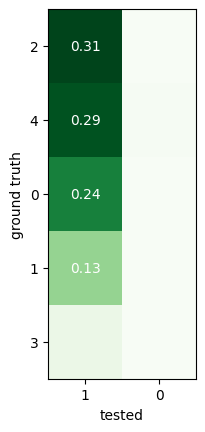

In [12]:
comp = si.compare_sorter_to_ground_truth(gt_sorting, sorting)
si.plot_agreement_matrix(comp)

## lets run another sorter

In [13]:
sorter_name = "tridesclous2"

sorter_folder = base_folder / f"drift_{sorter_name}"
if sorter_folder.exists():
    shutil.rmtree(sorter_folder)


sorting2 = si.run_sorter(sorter_name, recording, output_folder=sorter_folder, verbose=True)


write_memory_recording:   0%|          | 0/300 [00:00<?, ?it/s]

detect peaks using locally_exclusive:   0%|          | 0/300 [00:00<?, ?it/s]

We found 12402 peaks in total
We kept 12402 peaks for clustering


extract waveforms shared_memory mono buffer:   0%|          | 0/300 [00:00<?, ?it/s]

pipeline:   0%|          | 0/300 [00:00<?, ?it/s]

In [18]:
analyzer2 = si.create_sorting_analyzer(sorting2, recording, sparse=False)
analyzer2.compute(["random_spikes", "waveforms", "templates", "noise_levels"], **job_kwargs)
analyzer2.compute(["spike_amplitudes", "unit_locations", "principal_components", "correlograms", "template_similarity"], **job_kwargs)
analyzer2.compute("quality_metrics", metric_names=["snr", "amplitude_cutoff", "rp_violation"])
analyzer2

compute_waveforms:   0%|          | 0/300 [00:00<?, ?it/s]

spike_amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/19 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/19 [00:00<?, ?it/s]

/home/samuel/Documents/SpikeInterface/spikeinterface/src/spikeinterface/qualitymetrics/misc_metrics.py:846: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")


SortingAnalyzer: 4 channels - 19 units - 1 segments - memory - has recording
Loaded 10 extenstions: random_spikes, waveforms, templates, noise_levels, spike_amplitudes, unit_locations, principal_components, correlograms, template_similarity, quality_metrics

In [19]:
%gui qt
si.plot_sorting_summary(analyzer2, backend="spikeinterface_gui")

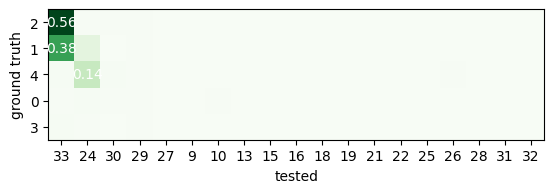

In [20]:
comp2 = si.compare_sorter_to_ground_truth(gt_sorting, analyzer2.sorting)
si.plot_agreement_matrix(comp2)